#### Notebook for estimating sparse vs dense throughput (tokens/sec)

# Estimation of throughput for sparse MoE Decoder Transformer Models

- MoE models have sublinear compute cost with respect to number of parameters
- This sparse architecture offers drastically growing model size for higher accuracy while consuming lower training cost
- The limiting boundary for sparse models is the memory wall of GPUs
    - However sparse nature of expert layers offer much improved scope for efficient tensor sharding across devices without the need of cross-device communication
- Number of parameters of a MoE model can be increased by the following two ways:
    - Scale the base Model: Increases both the number of parameters and the computation per token
    - Scale the number of Experts: Increases the model parameters at the same compute per token
- However just increasing the number of experts leads to model overfitting and generally poor performance in case of distribution shift during fine tuning
- Hence a balance between the number of experts and computation per token needs to be maintained


- **Microsoft DeepSpeed MoE:** is a system capable of scaling MoE models to trillions of parameters. It is an open source library which implements DeepSpeed MoE training
- In addition to the 4 different types of parallelism used in Switch transformers, DeepSpeed MoE offers the following improvements:
    - Zero Redundancy Optimizer (ZeRO) for reduced memory overhead resulting from data parallelism
    - Transcending GPU memory wall with ZeRO Offload where optimizer states and gradients are not only partitioned across different devices, but also offloaded to the CPU memory
    - Effective training methods for token selection which handles overflown tokens more efficiently and improves the sample efficiency
    - Effective training recipes to scale up multitask and multilingual language models with MoE model architecture
    
    
- Utilizing these optimizations DeepSpeed MoE(Young Jin Kim et al., 2021) reported the following scaling throughput data (data observed on NVIDIA 40GB A100 GPUs)
![moe_scaling](moe_scaling.png)
- We use these readings to get an estimated throughput basis the number of GPUs used for a given sparse model input size
- The results help to approximate that 1 40GB A100 GPU can hold 0.78B parameter sparse model parameters


## Methodology:

1. Calculate the total parameters of sparse models given the following inputs<br>
    1.1. Base Model Size<br>
    1.2. Hidden Size<br>
    1.3. Number of MoE layers<br>
    1.4. Number of Experts<br>
2. Find the total number of 40GB A100 GPUs required to fit the model size(using a factor of 0.78B/GPU)
3. Find required number of GPUs required on using DeepSpeed MoE
4. Get throughput(tokens/second) for the calculated #gpu
5. Divide the total training tokens by the observed throughput for aggregate number of GPUs for estimated training time
6. Calculate CO2e using the total training time, number of GPUs, data centre PUE, and regional CO2 emissions data


### A closer look at the total number of parameters in decoder transformer models

Narayanan et al., 2021 calculated the total number of parameters in a dense transformer model as 
$$P = 12lh^2\left(1 + \frac{13}{12h} + \frac{V+s}{12lh}\right)$$
where,
- l: number of layers
- h: hidden size
- V: vocabulary size
- s: sequence length

In high parameter models we find that $12lh >> (V+s)$. Hence a rough estimation of this total parameters is $P \approx 12lh^2$. Hence given a model with $l$ layers parameters per layer is $12h^2$

Breaking down this parameter count by components in  a GPT layer:
- Self-Attention Parameters
    - Q,K,V matrices: $3*H^2$
    - Output projection matric: $H^2$
- Feedforward(FF) Parameters: FF layer increases the hidden size to 4h before bringing it down to H after the second projection
    - First Linear transformation: $4*H^2$
    - Second Linear Projection: $4*H^2$
- Total Parameter Contribution per layer
    - Self Attention: $4h^2$
    - FeedForward layers: $8h^2$
- In a typical MoE sparse model every other Feedforward layer is replaced by a MoE layer. Hence
    - Number of MoE layers $l_{MoE}$ is $l/2$
    - Number of regular FF layer $l_{ff}$ is $l/2$
- Hence total parameters given by regular FF layers is $P_{ff} = P/2$ where $P_{ff} = 12l_{ff}h^2\left(1 + \frac{13}{12h} + \frac{V+s}{12l_{ff}h}\right)$
- Total parameters contributed by MoE layer is $P_{Expert} + P_{attn}$ where $P_{Expert}$ is total number of expert parameters per layer and $P_{attn}$ is total parameters from self attention in MoE layer
- $P_{Expert} = 8h^2*E_n$ where $E_n$ is the number of experts per MoE layer
- $P_{attn} = 4h^2$ per MoE layer
- Total MoE parameters: $P_{MoE} = P_{Expert} + P_{attn}$
- Total Model Parameters: $P = P_{ff} + P_{MoE}$

Validation of this method is done by comparing model sizes for dense and sparse models (Rajbhandari et al.,2022)
![sparse_dense_size](sparse_dense_size.png)



## Estimating Throughput

- Scaling results in Young Jin Kim et al., 2021 show super linear scaling of throughput with respect to number of GPUs 
- Divide total sparse parameter model size with 0.78 for 40GB A100 GPU capcacity(for non DeepSpeed MoE). Divide this by 8 to get DeepSpeed configuration with ZeRO
- Get sparse model DeepSpeed throughput as a linear function of number of GPUs
    - slope: 2.64
    - intercept: 39.88
- Hence given a sparse transformer model architecture, we can calculate
    - Total Number of parameters in sparse model
    - Number of GPUs required to fit this model
    - Throughput given the total number of GPUs required
    - Total training time as $T/X$ where $X$ is estimated throughput(tokens/second)

### Function for dense and sparse models

***Note:*** The sparse models scaling data is based on throughput performance of 40GB A100 GPU clusters. While scaling data for Megatron uses 80GB A100 GPU. Hence the throughput(tokens/sec) is not comparable directly

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [74]:
## dense model regression coefficients
coeff_tensor = [-8.82079068e-20,  1.68591116e-09,  1.33954735e+02]
coeff_pipe = [-5.60233749e-23,  8.45435587e-11,  1.34546129e+02]
coeff_gpu_inter = [-3.48420436e-21,  6.13525744e-09,  3.91960713e+02]
coeff_gpu_intra = [1.31381254e-08, 1.77462653e+01]
coeff_batch = [0.0418642 , -2.46672581, 36.14288189]

# function to estimate tensor dimension intra-server 
func_tensor = np.poly1d(coeff_tensor)
#function to estimate pipe dimension inter-server 
func_pipe = np.poly1d(coeff_pipe)

# function to estimate total GPUs intra-server(linear) 
func_gpu = np.poly1d(coeff_gpu_intra)
# function to estimate total GPUs inter-server 
func_gpu_i = np.poly1d(coeff_gpu_inter)

# function to estimate batch size per GPU
func_batch = np.poly1d(coeff_batch)

In [75]:
def get_model_size(experts, layers, h_size):
    '''calculate total sparse model parameter size and equivalent dense model size
    method:
    1. Let total FF layers l_ff = #layers/2, total MoE layers l_moe = #layers/2 
    2. Get total Non-Expert parameter size P_ff = P_l*l_ff where P_l is parameter per layer
    3. Get total parameter size for MoE FF Expert matrices P_moe_ff = 8*(hidden_state^2)*(#experts)
    4. Get total parameter size for MHA operations in MoE layers P_moe_mha = 4*(hidden_state^2)
    5. Get total Expert parameter for all MoE layer P_moe = (P_moe_ff + P_moe_mha)*l_moe
    6. Get total sparse model size P_sparse = P_ff + P_moe
    '''
    P_dense = 12*layers*(h_size**2)
    l_ff, l_moe = layers/2, layers/2
    P_l = P_dense/layers
    P_ff = P_l * l_ff
    
    P_moe_ff = 8*(h_size**2)*(experts)
    P_moe_mha = 4*(h_size**2)
    P_moe = (P_moe_ff + P_moe_mha)*l_moe
    
    P_sparse = P_ff + P_moe
    
    return P_sparse, P_dense

def get_pt(P, node_size, gpu_cap):
    '''return required model parallel degree'''
    P = P/1e9
    # model parallel size
    if P < node_size*gpu_cap:
        p_size = 1
        t_size = int(np.ceil(P/gpu_cap))
    else:
        t_size = node_size
        p_size = int(np.ceil(P/(node_size*gpu_cap)))

    model_size = t_size * p_size    
    return p_size, t_size

def get_n(P, p_size, t_size, gpu_type, gpu_mem):
    '''return required number of GPUs(p*t*d)'''
    model_size = p_size*t_size
    if p_size == 1:
        #intra model
        num_gpu = np.round(func_gpu(P)/model_size)*model_size
    else:
        #inter model
        num_gpu = np.round(func_gpu_i(P)/model_size)*model_size
#     if 'V100' in gpu_type:
#         num_gpu = np.round(num_gpu * 2.5) #V100 is 32GB
        
    if gpu_mem == 40:
        num_gpu *= 2
    return num_gpu

def get_sparse_gpu(P_sparse, node_size):
    dpmoe_gpu = np.round((P_sparse/1e9)/0.78, node_size)*node_size
    # ds_gpu = np.round(dpmoe_gpu/8, node_size)*node_size
    ds_gpu = dpmoe_gpu/8
    return np.round(dpmoe_gpu), np.round(ds_gpu)

def get_batch(P, p_size, d_size, num_gpu):
    '''return global batch size'''
    P = np.log(P)
    b_n = func_batch(P)
    b = num_gpu*np.exp(b_n)
    #round off to nearest multiple of p*d
    return np.round(b/(p_size*d_size))*(p_size*d_size)

def get_throughput(P, p_size, t_size, node_size, gpu_type, rel_thru):
    '''return throughput for the model size'''
    #intra model condition
    if (t_size <= node_size and p_size == 1):
        X = func_tensor(P)
    # inter model     
    else:
        X = func_pipe(P)

    #throughput scaling for V100 (needs revision)
    if 'V100' in gpu_type:
        X_new = X -  X*rel_thru
        peak_new = X_new /312
        X_scaled = peak_new*125
    else:
        X_scaled = X    
    
    return X_scaled

def get_sparse_throughput(ds_gpu):
    '''get sparse throughput(tokens/sec) for DPMoE and DeepSpeed
    using a slope of 2.64 and intercept of 39.88'''
    X_sparse = ds_gpu*(2.64) + 39.88
    return X_sparse

def get_train_time(P, tokens, num_gpu, throughput, model_type):
    '''return total training compute FLOPs and time'''
    ## Factor of 6 for dense and 3 for sparse models 
    flop_per_parameter = 6
    if 'T5' in model_type:
        flop_per_parameter = 3
    
    total_compute = P*tokens*flop_per_parameter
    total_compute_per_sec = num_gpu*throughput*1e12
    
    train_sec = total_compute / total_compute_per_sec
    
    return train_sec, total_compute

def get_co2e(gpu_tdp, train_time, region_co2, pue, n):
    '''return total co2e as a function of train time, num of gpu, pue, and regional co2 data'''
    co2_gpu = gpu_tdp * train_time * region_co2 * pue
    co2_gross = co2_gpu*n
    return co2_gross

def flop_to_tokens_sec(P_dense, X_dense):
    '''function to convert throughput for dense models 
    from FLOPs per GPU to tokens processed per GPU'''
    flop_token = 6*P_dense
    tokens_per_sec = np.floor(flop_token/X_dense)
    return tokens_per_sec

From Megatron Scaling Study:
![scale_data](scale_data.png)

### Sparse vs Dense Model throughput for models sizes used in Megatron-LM 

We use the approximation of $12*\text{num_layers}*\text{hidden_size}^2$ for both sparse and dense models. Assumption is model size are in the range such that $(V+s) << 12lh$

In [76]:
#import data
#calculate total parameters
scale_data = pd.read_csv('scaling_data.csv')
scale_data['data_model_size'] = (scale_data['#gpus']/(scale_data['tensor_model_size']*scale_data['pipeline_model_size'])).astype(int)
scale_data['batch_gpu'] = scale_data['batch_size']/scale_data['#gpus']

e = 64
node_size = 8
gpu_mem = 80
gpu_type = 'A100'
gpu_cap = gpu_mem*0.03
node_cap = gpu_cap*node_size
#relative throughput speedup ratio for 8X V100 vs A100 throughput
rel_thru = 7.76/33.46 

scale_data['experts'] = e

#sparse calculations
scale_data['P_sparse'], scale_data['P_dense'] = zip(*scale_data.apply(lambda row: get_model_size(row['experts'], row['number_of_layers'], row['hidden_size']), axis=1))
scale_data['est_gpu_dpmoe'], scale_data['est_gpu_deepspeed'] = zip(*scale_data.apply(lambda row: get_sparse_gpu(row['P_sparse'], node_size), axis=1))
scale_data['X_sparse'] = scale_data.apply(lambda row: get_sparse_throughput(row['est_gpu_deepspeed']), axis=1)

#dense calculations
scale_data['est_pipe_size'], scale_data['est_tensor_size'] = zip(*scale_data.apply(lambda row: get_pt(row['P_dense'], node_size, gpu_cap), axis=1))
scale_data['est_gpu_dense'] = scale_data.apply(lambda row: get_n(row['P_dense'], row['est_pipe_size'], row['est_tensor_size'], gpu_type, gpu_mem), axis=1)
scale_data['X_dense_FLOPs'] = scale_data.apply(lambda row: get_throughput(row['P_dense'], row['est_pipe_size'], row['est_tensor_size'], node_size, gpu_type, rel_thru), axis=1)

#convert dense FLOPs to tokens_per_sec
scale_data['X_dense'] = scale_data.apply(lambda row: flop_to_tokens_sec(row['P_dense'], row['X_dense_FLOPs']), axis=1)
scale_data['X_dense'] = np.floor(scale_data['X_dense']/1000)
scale_data.to_csv('all_data.csv', index=None)

### Plot All graphs for dense and sparse

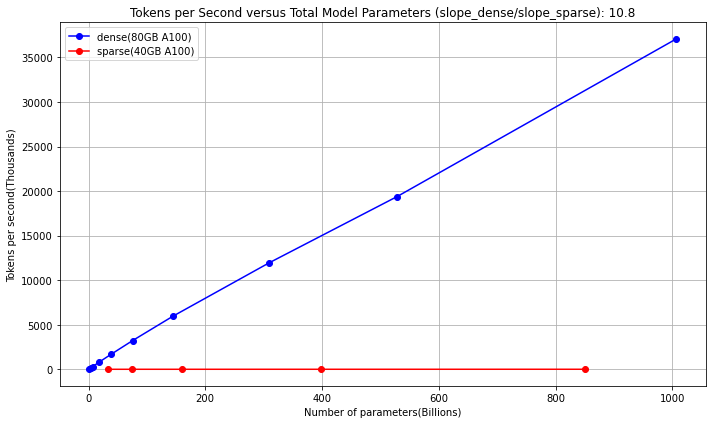

In [83]:
plt.figure(figsize=(10,6))
plt.plot(scale_data['P_dense']/1e9, scale_data['X_dense']/1e3, marker='o', color='b', label='dense(80GB A100)')
filt_data = scale_data[scale_data['P_sparse'] <= scale_data['P_dense'].max()]
plt.plot(filt_data['P_sparse']/1e9, filt_data['X_sparse']/1e3, marker='o', color='r', label='sparse(40GB A100)')
plt.legend()
plt.xlabel('Number of parameters(Billions)')
plt.ylabel('Tokens per second(Thousands)')
plt.grid()
plt.title('Tokens per Second versus Total Model Parameters (slope_dense/slope_sparse): {:.1f}'.format(10.8))
plt.tight_layout()
plt.savefig('dense_sparse_40_80.png')
plt.show()
plt.close()

### Observations
1. Megatron-LM data is trained on 80GB A100 NVIDIA GPU server while the DeepSpeed MoE is trained on 40GB A100 NVIDIA GPUs
2. We expect the MoE throughput to be lower but due to this difference the rate of increase of dense throughput(tokens/sec) is 10.8 times that of sparse model parameters $\frac{slope_{dense}}{slope_{sparse}} = 10.8$
3. [LambdaLabs](https://lambdalabs.com/gpu-benchmarks) reports a comparison benchmark for PCIe A100 80 vs 40 GB to be $\frac{3.76}{2.85}=1.32$
4. Assuming this relative benchmark is applicable for sparse model training we have plotted another graph for throughput versus number of parameters below. Here we have scaled the throughput of 40GB A100 performance by a factor of 1.32
5. After scaling up throughput for 40GB A100 to match relative performance of 80GB A100 $\frac{slope_{dense}}{slope_{sparse}} = 8.2$

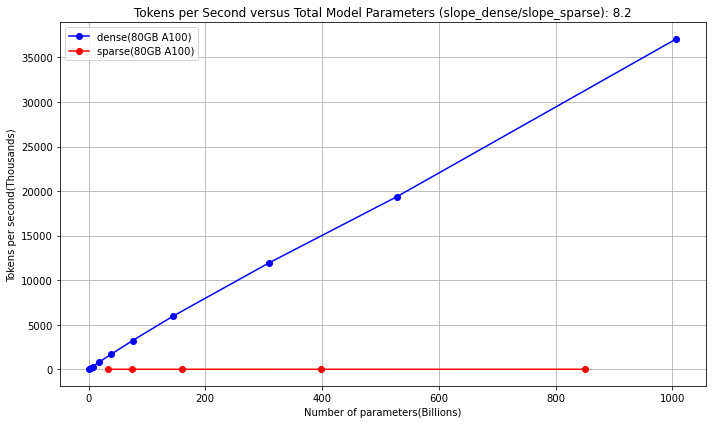

In [84]:
plt.figure(figsize=(10,6))
plt.plot(scale_data['P_dense']/1e9, scale_data['X_dense']/1e3, marker='o', color='b', label='dense(80GB A100)')
filt_data = scale_data[scale_data['P_sparse'] <= scale_data['P_dense'].max()]
plt.plot(filt_data['P_sparse']/1e9, (filt_data['X_sparse']/1e3)*1.32, marker='o', color='r', label='sparse(80GB A100)')
plt.legend()
plt.xlabel('Number of parameters(Billions)')
plt.ylabel('Tokens per second(Thousands)')
plt.grid()
plt.title('Tokens per Second versus Total Model Parameters (slope_dense/slope_sparse): {:.1f}'.format(8.2))
plt.tight_layout()
plt.savefig('dense_sparse_80_80.png')
plt.show()
plt.close()

In [78]:
from sklearn.linear_model import LinearRegression

dense_x = scale_data['P_dense'] / 1e9  
dense_y = scale_data['X_dense'] / 1e3 

sparse_x = filt_data['P_sparse'] / 1e9
sparse_y = filt_data['X_sparse']

#linear regression to get slope of above line
dense_model = LinearRegression().fit(dense_x.to_numpy().reshape(-1, 1), dense_y.to_numpy())
sparse_model = LinearRegression().fit(sparse_x.to_numpy().reshape(-1, 1), sparse_y.to_numpy())

dense_slope = dense_model.coef_[0]
sparse_slope = sparse_model.coef_[0]

print('dense_slope/sparse_slope: {}'.format(dense_slope/sparse_slope))

dense_slope/sparse_slope: 10.834908534901501


In [72]:
dense_x = scale_data['P_dense'] / 1e9  
dense_y = scale_data['X_dense'] / 1e3 

sparse_x = filt_data['P_sparse'] / 1e9
sparse_y = filt_data['X_sparse']*1.32

#linear regression to get slope of above line
dense_model = LinearRegression().fit(dense_x.to_numpy().reshape(-1, 1), dense_y.to_numpy())
sparse_model = LinearRegression().fit(sparse_x.to_numpy().reshape(-1, 1), sparse_y.to_numpy())

dense_slope = dense_model.coef_[0]
sparse_slope = sparse_model.coef_[0]

print('dense_slope/sparse_slope: {}'.format(dense_slope/sparse_slope))

dense_slope/sparse_slope: 8.208264041592043
